In [18]:
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
import datetime as dt
import dill
# Check current directory
import os
print(os.getcwd())

/Users/sethblum/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Courses/1C51/project-repo/FinalProject_1.C01


In [56]:
modelpath = 'Model_Outputs/model_BiLSTM_3layers_2024-05-06 11:48:50.924766.keras'
model = load_model(modelpath)
predspath = 'Model_Outputs/predictions_BiLSTM_3layers_2024-05-07 07:53:52.513658.csv'
preddf = pd.read_csv(predspath)

data = pd.read_pickle('X_test.pkl')
Xscaler = pd.read_pickle('Xscaler.pkl')

In [57]:
data = pd.DataFrame(Xscaler.inverse_transform(data[:,0:4]))
DAM = data[0]
preddf['DAM'] = DAM

In [58]:
preddf.drop(columns=['Unnamed: 0'], inplace=True)
preddf

,Actual,Predicted,DAM
0,47.97,50.687680,58.38
1,45.04,52.470524,58.38
2,41.90,46.717426,47.97
3,37.24,47.057660,47.97
4,3.95,47.797604,47.97
...,...,...,...
55815,12.08,15.712752,15.95
55816,12.40,16.465582,17.07
55817,12.77,16.689707,17.07
55818,12.80,16.912886,17.07


In [59]:
# scalerX = dill.load(open('Xscaler.pkl', 'rb'))
# scalerY = dill.load(open('Yscaler.pkl', 'rb'))
# # Load the data
# X_train_encoded = dill.load(open('X_train_encoded.pkl', 'rb'))
# X_test_encoded = dill.load(open('X_test_encoded.pkl', 'rb'))
# y_train_encoded = dill.load(open('y_train_encoded.pkl', 'rb'))
# y_test_encoded = dill.load(open('y_test_encoded.pkl', 'rb'))
# # TODO need to add
# y_test_notscaled = dill.load(open('raw_y_test.pkl', 'rb'))

In [60]:
# Define function to compare and plot model predictions from actual values
# Allow to zoom into a certain interval on the x axis

def plot_comparison(predictions, actual, DAM = None, startx=None, endx=None, starty=None, endy=None):
    """
    Plot the predicted vs actual values with an optional x-axis limit.

    Parameters:
        predictions (array-like): The predicted values.
        actual (array-like): The actual values.
        start (int, optional): Start index for x-axis limit.
        end (int, optional): End index for x-axis limit.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(predictions, label='Predicted')  # Added markers for better visibility
    plt.plot(actual, label='Actual')  # Added markers for better visibility
    if DAM is not None:
        plt.plot(DAM, label='DAM')
    plt.legend()
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        plt.ylim(preddf['Actual'][startx:endx].min(), preddf['Actual'][startx:endx].max())
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.title('Comparison of Predictions and Actual Values ('+predspath[41:57]+')')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

    
    # Plot the differences between the actual value and the predicted value
    plt.figure(figsize=(12, 6))
    
    # Set x-axis limits if specified
    if startx is not None or endx is not None:
        plt.xlim(startx, endx)
        
    # Set y-axis limits if specified
    if starty is not None or endy is not None:
        plt.ylim(starty, endy)    
    
    plt.plot(predictions - actual, label='Difference')
    plt.legend()
    print('everything but show')
    plt.show()
    print('done')
    return
    

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(preddf['Actual'], preddf['Predicted'])
print('mse'+str(mse/len(preddf['Actual'])))

mae = mean_absolute_error(preddf['Actual'], preddf['Predicted'])
print('mae'+str(mae / len(preddf['Actual'])))


mse1.0039052108974826
mae0.001119357032373089


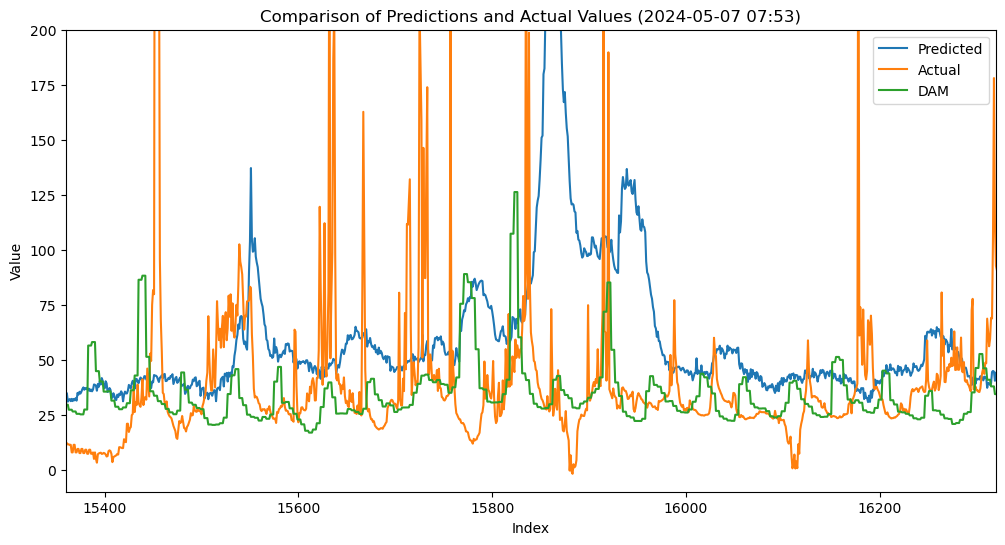

everything but show


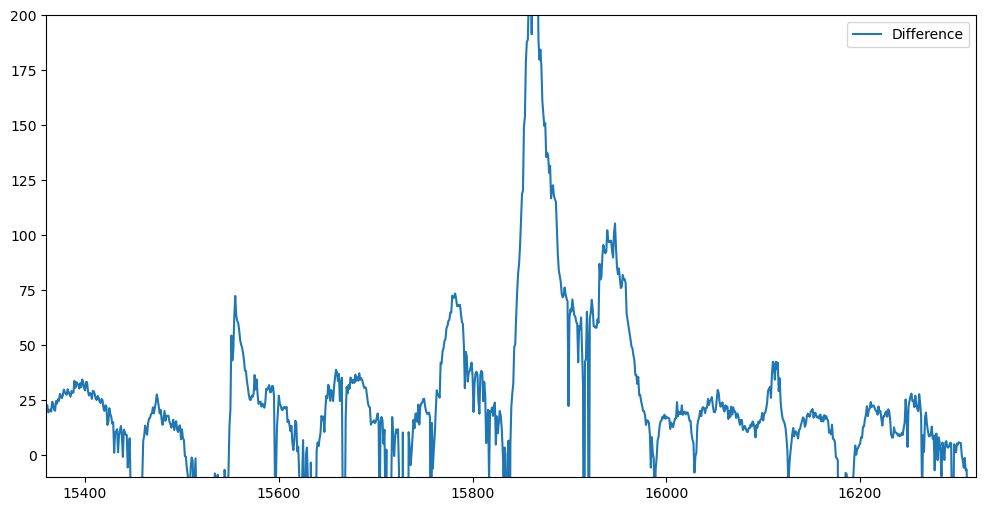

done


In [62]:
plot_comparison(preddf['Predicted'], preddf['Actual'],preddf['DAM'], startx=96*160, endx=0+96*170, starty=-10, endy=200)

In [63]:

def get_category(value):
    if value >= 25:
        return 3
    elif value >= 0:
        return 2
    elif value >= -25:
        return 1
    else:
        return 0

preddf['Actual Category'] = (preddf['Actual']-preddf['DAM']).apply(get_category)
preddf['Predicted Category'] = (preddf['Predicted']-preddf['DAM']).apply(get_category)

In [64]:
preddf['CatAccuracy'] = preddf['Actual Category'] == preddf['Predicted Category']

In [65]:
preddf['CatAccuracy']

0         True
1         True
2         True
3         True
4        False
         ...  
55815     True
55816     True
55817     True
55818     True
55819     True
Name: CatAccuracy, Length: 55820, dtype: bool

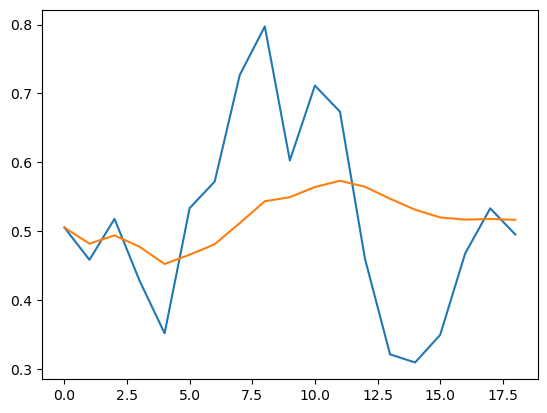

In [66]:
catdays = []
runningcatdays = []
for i in range(1,len(preddf['CatAccuracy'])):
    if i % (96*30) == 0:
        catdays.append(preddf['CatAccuracy'][i:i+96*30].sum()/len(preddf[i:i+96*30]))
        runningcatdays.append(sum(catdays)/len(catdays))


plt.plot(catdays)
plt.plot(runningcatdays)
plt.show()

In [71]:
signdiff = np.sign(preddf['Predicted']-preddf['DAM']) == np.sign(preddf['Actual']-preddf['DAM'])

preddf

signdays = []
for i in range(1,len(signdiff)):
    if i % (96* 30) == 0:
        signdays.append(signdiff[i:i+96 * 30].sum()/len(signdiff[i:i+96 * 30]))

In [68]:
print(signdiff.sum()/len(signdiff))

0.7644213543532784


/Users/sethblum/anaconda3/envs/joint1c51/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sethblum/anaconda3/envs/joint1c51/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


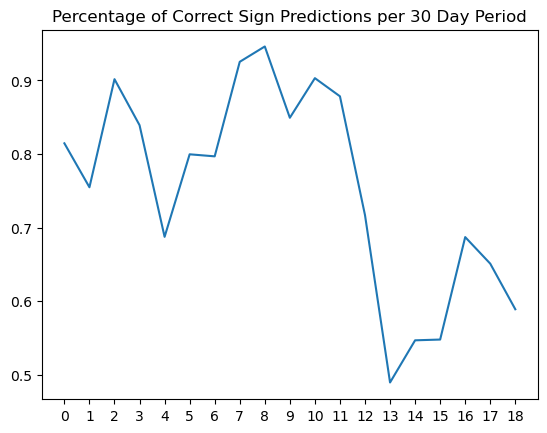

/Users/sethblum/anaconda3/envs/joint1c51/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

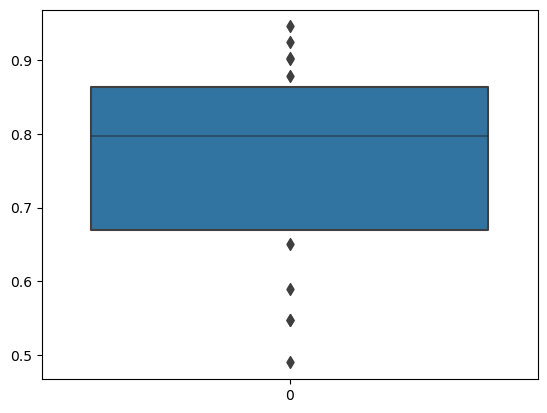

In [74]:
sns.lineplot(x=range(len(signdays)), y=signdays)
plt.title('Percentage of Correct Sign Predictions per 30 Day Period')

# Set the x-axis tick values to integer values
plt.xticks(range(len(signdays)), range(len(signdays)))

plt.show()
sns.boxenplot(signdays)

In [70]:
(np.sign(preddf['Predicted']-preddf['DAM'])).sum()/len(preddf)

0.0853099247581512